# Sounding Rocket

Parameters:
- Mass = 2 kg dry mass, 1 kg propellant
- Length = 1 m long
- Engine specific impulse = 1500 m/s
- Engine burn time = 5 s
- Ignore aerodynamic forces

Coordinate system:
- x points East
- y points North
- z points up

In [25]:
import cusfkiwi as kiwi
import numpy as np
from scipy.spatial.transform import Rotation    # Used to convert Euler angles to quaternions
import matplotlib.pyplot as plt

### Initial State

In [26]:
# Start with a 5 degree incline towards the East
r = Rotation.from_euler('y', -85, degrees = True) # x-axis on body nearly aligns with z-axis of launch site frame

# Initial conditions:
init_state = kiwi.State(time = 0, 
                        pos = [0, 0, 0], 
                        vel = [0, 0, 0],
                        ang_pos = r.as_quat(), 
                        ang_vel = [0, 0, 0])

### Mass

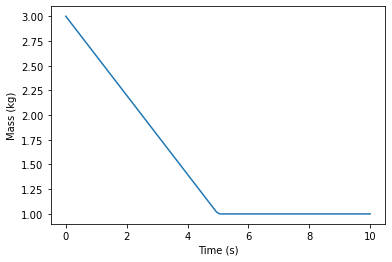

In [27]:
# Mass
def mass_func(t):
    if t < 5:
        return 3 - 2 * t/5           # 1 kg of propellant, burnt at a constant rate over 5 seconds
    else:
        return 1
    
mass = kiwi.Mass(mass_func, 'time')  # Function of time

# Plot to show what we're using
t_plot = np.linspace(0, 10, 100)
mass_plot = np.zeros(len(t_plot))

for i in range(len(t_plot)):
    mass_plot[i] = mass_func(t_plot[i])

plt.plot(t_plot, mass_plot)
plt.xlabel("Time (s)")
plt.ylabel("Mass (kg)")
plt.show()

### Moments of Inertia

Approximately as a cylinder (Iyy = Izz = ml^2 / 12)

Ixx must be none zero to avoid a divide by zero error.

In [28]:
def m_o_i_func(t):
    # Rocket's x-x points along it's long axis
    Ixx = 1e-2
    Iyy = mass_func(t) / 12
    Izz = Iyy
    
    return [Ixx, Iyy, Izz]
    
moments_of_inertia = kiwi.MomentsOfInertia(m_o_i_func, 'time')

### Forces

In [29]:
mdot = 1 / 5        # Mass flow rate of engine exhaust

def thrust_func(state):
    t = state.time
    r = Rotation.from_quat(state.ang_pos)
    
    if t < 5:
        thrust = mdot * 1500    # Specific impulse of 1500 s
    else:
        thrust = 0
        
    thrust_body_frame = [thrust, 0, 0]
    thrust_absolute_frame = r.apply(thrust_body_frame)    # Rotate thrust to align with body axes
    
    return thrust_absolute_frame

def gravity_func(t):
    return [0, 0, -9.81 * mass_func(t)]

thrust = kiwi.Force(thrust_func, "state")
gravity = kiwi.Force(gravity_func, "time")

forces = [thrust, gravity]

### Moments

Neglect any moments for now. The main ones would be aerodynamic forces.

In [30]:
moments = []     # Neglect any moments for now

### Set up Body and Simulation

In [31]:
rocket = kiwi.Body(init_state, mass, moments_of_inertia, forces, moments)

# Simulation
def end_condition(state):
    z = state.pos[2]
    t = state.time
    
    if t < 5:
        return False
    elif z > 0:
        return False
    else:
        return True

simulation = kiwi.Simulation(rocket, dt = 0.1, end_condition = end_condition)
simulation.run()

### Plot

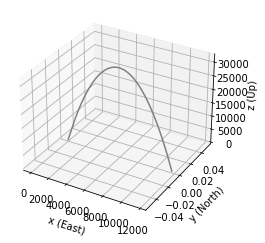

In [32]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(simulation.x(), simulation.y(), simulation.z(), 'gray')
ax.set_xlabel("x (East)")
ax.set_ylabel("y (North)")
ax.set_zlabel("z (Up)")
plt.show()